In [1]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr
from stingray import stats


sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *

def minimize_remainder(arr, min_div, max_div):
    divisors = np.linspace(min_div, max_div, num=100)
    remainders = []
    for div in divisors:
        remainders.append(np.sum(np.mod(arr, div)))
        
    return divisors[np.argmin(remainders)]

def power_law(f, B, gamma):
    return B*np.power(f,gamma)

def Lorentzian(f, peakf, Q, A):
    gamma = peakf/(2.0 * Q)
    return (A * np.square(gamma)/(np.pi*gamma*(np.square(f-peakf) + np.square(gamma))))

def Lorentzian_C(f, peakf, Q, A, C):
    return Lorentzian(f, peakf, Q, A) + C

def Lorentzian_power(f, peakf, Q, A, B, gamma):
    return Lorentzian(f, peakf, Q, A) + power_law(f, B, gamma)

def N_Lorentzians(f, *args):
    N = int((len(args)-1)/3)
    peaks = args[:N]
    Qs = args[N:N+N]
    As = args[N+N:N+N+N]
    B, gamma = args[-2:]
    model = power_law(f, B, gamma)
    for i in range(N):
        gamma = peaks[i]/(2.0 * Qs[i])
        model = model + (As[i] * np.square(gamma)/(np.pi*gamma*(np.square(f-peaks[i]) + np.square(gamma))))
        
    return model


def QPO_scan(cross_spec, f_min=1e-4, f_max=2000., f_bin=1000):
    f_mask = (cross_spec.freq > f_min) * (cross_spec.freq < f_max)
    freq_steps = np.logspace(np.log10(cross_spec.freq[f_mask][0]), np.log10(cross_spec.freq[f_mask][-1]), f_bin + 2)
    xdata = cross_spec.freq[f_mask]
    ydata = cross_spec.power[f_mask]
    sigma = cross_spec.power_err[f_mask]
    
    pl_popt, pl_pcov = scipy.optimize.curve_fit(power_law, xdata, ydata, sigma = sigma, p0 = [10., -1.0], \
                                                bounds=np.array([(0.0, np.inf), (-np.inf, 0.0)]).T)
    print(pl_popt)
    chisq0 = np.sum(((ydata - power_law(xdata, *pl_popt)) / sigma) ** 2)
    chisq = []
    for i in tqdm(range(len(freq_steps[1:-1]))):
        f = freq_steps[i+1]
        popt, pcov = scipy.optimize.curve_fit(Lorentzian_power, xdata, ydata, sigma = sigma, p0 = [f, 2.0, 0.1, pl_popt[0], pl_popt[1]], \
                                              bounds=np.array([(f - (f-freq_steps[i])/2., f + (freq_steps[i+2] - f)/2.0), (1.0,np.inf), (0.0,np.inf), (0.0, np.inf), (-np.inf, 0.0)]).T)
        chisq.append(np.sum(((ydata - Lorentzian_power(xdata, *popt)) / sigma) ** 2))
    dof = len(xdata)-len(popt)
    return freq_steps[1:-1], chisq0, np.array(chisq), dof


def sim_Poisson_cospectra(lc_len, dt, mean_rate_A, mean_rate_B, n_lc):
    # Simulate a number of cross spectra due to Poisson noise.
    
    cross_spectra = []
    lc_times = np.linspace(0.,lc_len, int(np.floor(lc_len/dt)))
    
    for i in range(n_lc):
        sim_lc_counts_A = np.random.poisson(mean_rate_A*dt, size = np.shape(lc_times))
        sim_lc_counts_B = np.random.poisson(mean_rate_B*dt, size = np.shape(lc_times))
        lcA = lc.Lightcurve(lc_times, sim_lc_counts_A, dt=dt)
        lcB = lc.Lightcurve(lc_times, sim_lc_counts_B, dt=dt)
        cross = crossspec.Crossspectrum(lcA, lcB, norm='leahy')
        cross_spectra.append(cross)
    
    averaged_cross = cross_spectra[0]

    averaged_cross.m = len(cross_spectra)

    for i in range(len(cross_spectra))[1:]:
        averaged_cross.power += cross_spectra[i].power
        averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
        averaged_cross.power_err += np.square(cross_spectra[i].power_err)
        averaged_cross.nphots1 += cross_spectra[i].nphots1
        averaged_cross.nphots2 += cross_spectra[i].nphots2

    averaged_cross.power = averaged_cross.power/averaged_cross.m
    averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
    averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
    averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
    averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m
    
    return averaged_cross

def QPO_sim(Q, A, peakf, lc_len, dt, mean_rate_A, mean_rate_B, n_lc, f_min, f_max, num_trials = 100):
    # Simulate many cospectra due to Poisson noise then model with and without a Lorentzian QPO.
    # Return the distribution of resulting improvements to the fit.
    
    delta_chisq = []

    for i in tqdm(range(num_trials)):
        cross = sim_Poisson_cospectra(lc_len, dt, mean_rate_A, mean_rate_B, n_lc)
        f_mask = (cross.freq > f_min) * (cross.freq < f_max)
        xdata = cross.freq[f_mask]
        ydata = cross.power[f_mask]
        sigma = cross.power_err[f_mask]
        chisq0 = np.sum(((ydata -np.mean(ydata)) / sigma) ** 2)
        popt, pcov = scipy.optimize.curve_fit(Lorentzian_C, xdata, ydata, sigma = sigma, p0 = [peakf, Q, A, 0.0], \
                                              bounds =np.array([(f_min, f_max), (0.99*Q, 1.01*Q), (0.99*A, 1.01*A), (-np.inf, np.inf)]).T)
        chisq = np.sum(((ydata - Lorentzian_C(xdata, *popt)) / sigma) ** 2)
        delta_chisq.append(chisq - chisq0)
    
    return delta_chisq

def log_likelihood(theta, f, p, p_err):
    # ln(likelihood of data given model)
    log_f = theta[-1]
    # Model is 2 Lorentzians plus a constant
    model = N_Lorentzians(f, p, *(theta[:-1]))
    
    sigma2 = p_err ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((p - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta, *mu_sigma):
    # ln(likelihood of model). Gaussian priors given by results of least square fit.
    # mu_sigma gives the mean and std dev of gaussian prior for each peak frequency, Q, and A.
    # It has the form [*peak frequencies mu, *Q mu, *A mu, *peak frequencies sigma, *Q sigma, *A sigma]
    # theta should have form [*peak frequencies, *Q, *A, C, log_f]
    N = int((len(theta)-2)/3)
    log_f = theta[-1]
    prior_params = np.array(theta[:-2])
    
    mu = np.array(mu_sigma[:N*3])
    sigma = mu_sigma[N*3:]
#     print((N))
    
    if (not np.sum(prior_params <= 0.0)) and (-10.0 < log_f < 1.0):
        return -np.sum(np.square((prior_params-mu)/sigma))/2.0
    else:
        return -np.inf

def log_probability(theta, f, p, p_err, *mu_sigma):
    # ln(likelihood of model given data) also the posterior
    
    lp = log_prior(theta, *mu_sigma)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, f, p, p_err)

def fit_peaks(xdata, ydata, sigma, nu_peak):
    
    popt_arr = []
    pcov_arr = []

    for i, p in enumerate(nu_peak):
        f_bound = None
        if i == 0:
            f_bound = (np.min(xdata), p + (nu_peak[i+1] - p)/2)
        elif i==len(nu_peak)-1:
            f_bound = (p + (nu_peak[i-1] - p)/2, np.max(xdata))
        else:
            f_bound = (p + (nu_peak[i-1] - p)/2, p + (nu_peak[i+1] - p)/2)

        par_bounds = np.array([f_bound, (1.0,np.inf), (0, np.inf), (0, np.inf), (-np.inf, 0.0)]).T
        p0 = [p, 5.0, 0.1, 0.02, -0.5]
        popt, pcov = scipy.optimize.curve_fit(Lorentzian_power, xdata, ydata, sigma = sigma, p0 = p0, bounds = par_bounds)
        popt_arr.append(popt)
        pcov_arr.append(pcov)

    popt_arr = np.array(popt_arr)
    pcov_arr = np.array(pcov_arr)

    return popt_arr, pcov_arr




# 2020

In [2]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/J1739m285/nustar/2020/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir='/Volumes/Samsung_1TB/AstroData/J1739m285/nustar/2020/'

timing_dir = root_dir + 'timing_products/'
products_dir = root_dir + 'products_3to78keV/'
plot_dir = root_dir + 'figures/'

OBSID = '90601307002'
    

Working on Macbook


In [3]:
burst1_gti = list(fits.open(root_dir + 'burst1/' + 'burst1_gti.fits')[1].data)
burst2_gti = list(fits.open(root_dir + 'burst2/' + 'burst2_gti.fits')[1].data)

burst_gti = [*burst1_gti, *burst2_gti]

persistent_gti = list(fits.open(root_dir + 'persistent_gti.fits')[1].data)

pre_burst1_gti = [[burst1_gti[0][0] - 10000, burst1_gti[0][0]]]
pre_burst2_gti = [[burst2_gti[0][0] - 10000, burst2_gti[0][0]]]

print(burst1_gti)
print(burst2_gti)
print(burst_gti)
print(persistent_gti)
print(pre_burst1_gti)
print(pre_burst2_gti)

[(319824471.2888854, 319824516.4585162)]
[(319838207.6183461, 319838246.4598603)]
[(319824471.2888854, 319824516.4585162), (319838207.6183461, 319838246.4598603)]
[(319800314.39138, 319824371.2888854), (319825016.4585162, 319838107.6183461), (319838746.4598603, 319861638.89138)]
[[319814471.2888854, 319824471.2888854]]
[[319828207.6183461, 319838207.6183461]]


/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:375: RuntimeWarning: underflow encountered in exp
  (c * ydiff ** 2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:399: RuntimeWarning: underflow encountered in exp
  (c * ydiff2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:409: RuntimeWarning: underflow encountered in true_divide
  dg_dA = g / amplitude
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:410: RuntimeWarning: underflow encountered in multiply
  dg_dx_mean = g * ((2. * a * xdiff) + (b * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:411: RuntimeWarning: underflow encountered in multiply
  dg_dy_mean = g * ((b * xdiff) + (2. * c * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:414: RuntimeWarning: underflow encountered i

Text(0, 0.5, 'NuSTAR count rate')

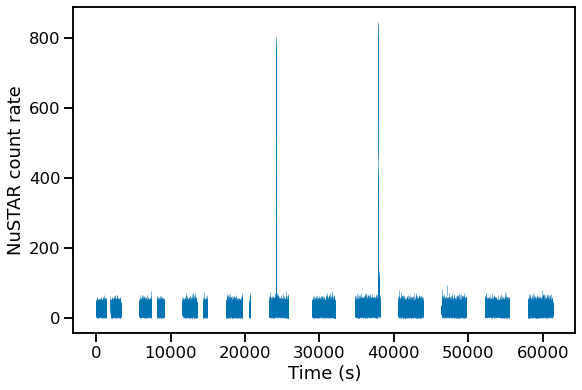

In [4]:
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
PI_max = 960   # 40.0 keV
# PI_max = 1909   # 78.0 keV
events = extract_events(timing_dir + 'nu' + OBSID + 'A01_cl_barycorr.evt', \
            timing_dir + 'nu' + OBSID + 'B01_cl_barycorr.evt')

centroid_A = [523.42071,455.48849]
centroid_B = [516.70582,454.38003]
extraction_radius = 46.783962

events[0].set_xy_weights(centroid=centroid_A)
events[1].set_xy_weights(centroid=centroid_B)
# joined_events = events[0].join(events[1])
# print(events[0].time)

plt.ion()

curveA = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc'))
curveB = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc'))
curve_total = sum_lc(curveA, curveB)
curve_10s = curve_total.rebin(dt_new=10)

t_start = np.min(curve_total.time)

plt.figure(figsize = (9,6))
plt.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel('NuSTAR count rate')
# plt.close()






## Persistent Cospectra

In [5]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, persistent_gti)])
len_mask = gti_lens > 500.
split_time = minimize_remainder(gti_lens[len_mask], 500,1500)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius) for x in events[0].split_by_time(bintime=split_time, gti=persistent_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius) for x in events[1].split_by_time(bintime=split_time, gti=persistent_gti)]



530.3030303030303


In [6]:
cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross_file = open(timing_dir + 'analysis_products/persistent_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'rb')
    cross = pickle.load(cross_file)
    cross_file.close()
    cross_spectra.append(cross)


100%|██████████| 53/53 [01:42<00:00,  1.93s/it]


In [7]:
plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m


# Scan for QPOs

In [21]:
f_min = np.min(averaged_cross.freq)
f_max = np.min([2000., (np.max(averaged_cross.freq))])
freqs, chisq0, chisq, dof = QPO_scan(averaged_cross, f_min=f_min, f_max=f_max, f_bin = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

[ 0.02250468 -0.54266683]


100%|██████████| 500/500 [30:14<00:00,  3.63s/it]


In [22]:
print(chisq0/dof)
plt.figure(figsize=(9,6))
plt.plot(freqs, (chisq - chisq0))
plt.xscale('log')
plt.ylabel(r'$\Delta\chi^{2}$')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig(plot_dir + 'persistent_QPO_scan.pdf')
plt.close()

1.0052637694047135


In [28]:
peaks, _ = scipy.signal.find_peaks(-(chisq - chisq0), height = 10.0)
QPO_candidates = []
f_mask = (averaged_cross.freq > f_min) * (averaged_cross.freq < f_max) 
xdata = averaged_cross.freq[f_mask]
ydata = averaged_cross.power[f_mask]
sigma = averaged_cross.power_err[f_mask]

popt_arr, pcov_arr = fit_peaks(xdata, ydata, sigma, freqs[peaks])

sigma_arr = []

for i in range(len(popt_arr)):
    print(popt_arr[i])
    print(np.sqrt(np.diag(pcov_arr[i])))
    sigma_arr.append(np.sqrt(np.diag(pcov_arr[i])))
sigma_arr = np.array(sigma_arr)
    

[ 0.96071466  1.3914513   0.11870611  0.01368072 -0.54085737]
[0.05170001 0.34058574 0.02148105 0.00276532 0.04536074]
[ 1.74946842e+02  1.86681550e+01  7.94273766e-02  2.21046255e-02
 -5.46591140e-01]
[3.81811866e+00 2.18006876e+01 6.64345550e-02 2.36668758e-03
 2.86202025e-02]


In [30]:
plt.ion()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
plt.plot(averaged_cross_log.freq, Lorentzian_power(averaged_cross_log.freq, *(popt_arr[0])), color='red')
plt.xscale('log')
plt.ylim((1e-4,1.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'persistent_averaged_cross_spectrum_' + str(int(split_time)) + 's_QPO_fit.pdf')
plt.close()



## Burst Cospectra

In [32]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, burst_gti)])
split_time = minimize_remainder(gti_lens, 10.,1000.)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius) for x in events[0].split_by_time(bintime=split_time, gti=burst_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius) for x in events[1].split_by_time(bintime=split_time, gti=burst_gti)]

print(curves_A[0].time)

10.0
[3.19824471e+08 3.19824471e+08 3.19824471e+08 ... 3.19824481e+08
 3.19824481e+08 3.19824481e+08]


In [33]:
cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross_file = open(timing_dir + 'analysis_products/burst_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'rb')
    cross = pickle.load(cross_file)
    cross_file.close()
    cross_spectra.append(cross)


100%|██████████| 7/7 [00:00<00:00, 30.31it/s]


In [34]:
plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m


# Scan for QPOs

In [35]:
f_min = np.min(averaged_cross.freq)
f_max = np.min([2000., (np.max(averaged_cross.freq))])
freqs, chisq0, chisq, dof = QPO_scan(averaged_cross, f_min=f_min, f_max=f_max, f_bin = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

[ 0.39249304 -2.08144222]


100%|██████████| 500/500 [00:32<00:00, 15.17it/s]


In [36]:
print(chisq0/dof)
plt.figure(figsize=(9,6))
plt.plot(freqs, (chisq - chisq0))
plt.xscale('log')
plt.ylabel(r'$\Delta\chi^{2}$')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig(plot_dir + 'burst_QPO_scan.pdf')
plt.close()

1.0251428366882231


In [37]:
peaks, _ = scipy.signal.find_peaks(-(chisq - chisq0), height = 10.0)
QPO_candidates = []
f_mask = (averaged_cross.freq > f_min) * (averaged_cross.freq < f_max) 
xdata = averaged_cross.freq[f_mask]
ydata = averaged_cross.power[f_mask]
sigma = averaged_cross.power_err[f_mask]

popt_arr, pcov_arr = fit_peaks(xdata, ydata, sigma, freqs[peaks])

sigma_arr = []

for i in range(len(popt_arr)):
    print(popt_arr[i])
    print(np.sqrt(np.diag(pcov_arr[i])))
    sigma_arr.append(np.sqrt(np.diag(pcov_arr[i])))
sigma_arr = np.array(sigma_arr)
    

[391.82005004  40.3718168    1.90689569   0.39236956  -2.08165295]
[ 3.32871147 39.16593875  1.30805331  0.08774524  0.14852445]
[ 7.43786303e+02  4.86666818e+01  2.65719357e+00  3.92384239e-01
 -2.08162861e+00]
[ 4.72042364 42.51608549  1.64141428  0.08774437  0.14851771]


In [39]:
plt.ion()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
plt.plot(averaged_cross_log.freq, Lorentzian_power(averaged_cross_log.freq, *(popt_arr[1])), color='red')
plt.xscale('log')
plt.ylim((1e-6,100.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'burst_averaged_cross_spectrum_' + str(int(split_time)) + 's_QPO_fit.pdf')
plt.close()



## Pre-Burst 1 Cospectra

In [5]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, pre_burst1_gti)])
split_time = minimize_remainder(gti_lens, 500.,1000.)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius) for x in events[0].split_by_time(bintime=split_time, gti=pre_burst1_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius) for x in events[1].split_by_time(bintime=split_time, gti=pre_burst1_gti)]

print(curves_A[0].time)

530.3030303030303
[3.19814714e+08 3.19814714e+08 3.19814714e+08 ... 3.19815245e+08
 3.19815245e+08 3.19815245e+08]


In [6]:
cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross_file = open(timing_dir + 'analysis_products/preburst1_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'rb')
    cross = pickle.load(cross_file)
    cross_file.close()
    cross_spectra.append(cross)


100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


In [8]:
plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m


# Scan for QPOs

In [9]:
f_min = np.min(averaged_cross.freq)
f_max = np.min([2000., (np.max(averaged_cross.freq))])
freqs, chisq0, chisq, dof = QPO_scan(averaged_cross, f_min=f_min, f_max=f_max, f_bin = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

[ 3.57138269e-09 -2.55496670e-01]


100%|██████████| 500/500 [32:08<00:00,  3.86s/it]


In [10]:
print(chisq0/dof)
plt.figure(figsize=(9,6))
plt.plot(freqs, (chisq - chisq0))
plt.xscale('log')
plt.ylabel(r'$\Delta\chi^{2}$')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig(plot_dir + 'preburst1_QPO_scan.pdf')
plt.close()

1.2921499300776347


In [11]:
peaks, _ = scipy.signal.find_peaks(-(chisq - chisq0), height = 10.0)
QPO_candidates = []
f_mask = (averaged_cross.freq > f_min) * (averaged_cross.freq < f_max) 
xdata = averaged_cross.freq[f_mask]
ydata = averaged_cross.power[f_mask]
sigma = averaged_cross.power_err[f_mask]

popt_arr, pcov_arr = fit_peaks(xdata, ydata, sigma, freqs[peaks])

sigma_arr = []

for i in range(len(popt_arr)):
    print(popt_arr[i])
    print(np.sqrt(np.diag(pcov_arr[i])))
    sigma_arr.append(np.sqrt(np.diag(pcov_arr[i])))
sigma_arr = np.array(sigma_arr)
    

[ 7.22891901e+01  3.44188317e+00  2.72297029e-01  1.14824525e-08
 -1.04282954e+00]
[1.18470236e+01 5.54546107e+00 3.08828604e-01 6.41245284e-03
 1.12107375e+05]
[ 1.14690120e+02  6.04958409e+01  2.09080406e-01  1.65170064e-19
 -6.83401472e-01]
[4.18392355e-01 3.77701679e+01 9.23210260e-02 5.56631149e-03
 0.00000000e+00]
[ 1.65007317e+02  4.34274208e+02  4.97924086e-02  1.62561130e-31
 -6.41442242e-01]
[1.57631662e-01 5.09605396e+02 4.13179233e-02 6.29171198e-03
 0.00000000e+00]
[ 6.59089571e+02  6.77632481e+01  2.52802191e-01  1.78228165e-10
 -8.35131319e-01]
[4.02107903e+00 7.92405818e+01 2.09035365e-01 3.84173088e-03
 2.96125494e+06]
[ 7.29389968e+02  1.23971991e+01  4.29335207e-01  8.88806156e-22
 -2.64249950e+00]
[3.52254045e+01 2.10037627e+01 5.14132319e-01 2.25783398e-07
 0.00000000e+00]
[ 1.54561289e+03  1.28472979e+02  2.54741742e-01  2.52693640e-10
 -6.10743939e-01]
[5.48949152e+00 1.65838930e+02 2.32566891e-01 6.80588987e-03
 1.40111256e+06]


In [12]:
plt.ion()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
plt.plot(averaged_cross_log.freq, Lorentzian_power(averaged_cross_log.freq, *(popt_arr[1])), color='red')
plt.xscale('log')
plt.ylim((1e-6,100.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst1_averaged_cross_spectrum_' + str(int(split_time)) + 's_QPO_fit.pdf')
plt.close()



## Pre-Burst 2 Cospectra

In [13]:
gti_lens = np.array([(g[1]-g[0]) for g in sting_gti.cross_two_gtis(events[0].gti, pre_burst2_gti)])
split_time = minimize_remainder(gti_lens, 500.,1000.)
print(split_time)
ms_bin = 0.0001
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius) for x in events[0].split_by_time(bintime=split_time, gti=pre_burst2_gti)]
curves_B = [x.to_lc(dt = ms_bin, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius) for x in events[1].split_by_time(bintime=split_time, gti=pre_burst2_gti)]

print(curves_A[0].time)

590.9090909090909
[3.19829428e+08 3.19829428e+08 3.19829428e+08 ... 3.19830018e+08
 3.19830018e+08 3.19830018e+08]


In [14]:
cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross_file = open(timing_dir + 'analysis_products/preburst2_cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'rb')
    cross = pickle.load(cross_file)
    cross_file.close()
    cross_spectra.append(cross)


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


In [15]:
plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m


# Scan for QPOs

In [16]:
f_min = np.min(averaged_cross.freq)
f_max = np.min([2000., (np.max(averaged_cross.freq))])
freqs, chisq0, chisq, dof = QPO_scan(averaged_cross, f_min=f_min, f_max=f_max, f_bin = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

[ 0.03476265 -0.56548118]


100%|██████████| 500/500 [40:12<00:00,  4.82s/it]    


In [17]:
print(chisq0/dof)
plt.figure(figsize=(9,6))
plt.plot(freqs, (chisq - chisq0))
plt.xscale('log')
plt.ylabel(r'$\Delta\chi^{2}$')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig(plot_dir + 'preburst2_QPO_scan.pdf')
plt.close()

1.0256696142479318


In [20]:
peaks, _ = scipy.signal.find_peaks(-(chisq - chisq0), height = 5.0)
QPO_candidates = []
f_mask = (averaged_cross.freq > f_min) * (averaged_cross.freq < f_max) 
xdata = averaged_cross.freq[f_mask]
ydata = averaged_cross.power[f_mask]
sigma = averaged_cross.power_err[f_mask]

popt_arr, pcov_arr = fit_peaks(xdata, ydata, sigma, freqs[peaks])

sigma_arr = []

for i in range(len(popt_arr)):
    print(popt_arr[i])
    print(np.sqrt(np.diag(pcov_arr[i])))
    sigma_arr.append(np.sqrt(np.diag(pcov_arr[i])))
sigma_arr = np.array(sigma_arr)
    

[ 4.92294422e-03  1.28211812e+02  4.83581911e-03  3.22889772e-02
 -5.45484924e-01]
[2.68415259e-03 6.36673731e-06 1.69024795e-01 5.50373135e-03
 4.95540065e-02]
[ 5.15464366e-03  2.12094955e+02  2.02155589e-03  3.23216351e-02
 -5.45883082e-01]
[5.35873855e-03 2.57184706e-06 2.70210197e-01 5.47971519e-03
 4.87304397e-02]
[ 0.99670554  9.8892878   0.04673578  0.03115371 -0.57175957]
[0.0157515  4.43134374 0.014988   0.00532231 0.04409153]
[ 4.92293470e+01  1.44164042e+01  4.35281939e-02  3.43092691e-02
 -5.68267354e-01]
[3.33538643e+00 4.03918806e+01 8.73966829e-02 5.26095006e-03
 4.05132966e-02]
[ 3.75691259e+02  9.27886274e+01  1.16603440e-01  3.43480700e-02
 -5.68656874e-01]
[1.60751810e+00 1.04473921e+02 9.30784258e-02 5.18247716e-03
 3.99293958e-02]
[ 9.05795877e+02  2.67188541e+01  5.21015420e-01  3.36009357e-02
 -5.75065862e-01]
[8.71627184e+00 1.96154981e+01 2.72990751e-01 5.25830773e-03
 4.15933946e-02]


In [22]:
plt.ion()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
plt.plot(averaged_cross_log.freq, Lorentzian_power(averaged_cross_log.freq, *(popt_arr[2])), color='red')
plt.xscale('log')
plt.ylim((1e-3,10.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'preburst2_averaged_cross_spectrum_' + str(int(split_time)) + 's_QPO_fit.pdf')
plt.close()



# 2019

In [41]:
if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/J1739m285/nustar/2019/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir='/Volumes/Samsung_1TB/AstroData/J1739m285/nustar/2019/'

timing_dir = root_dir + 'timing_products/'
products_dir = root_dir + 'products_3to78keV/'
plot_dir = root_dir + 'figures/'

OBSID = '90501343002'
    

Working on Macbook


/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:375: RuntimeWarning: underflow encountered in exp
  (c * ydiff ** 2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:399: RuntimeWarning: underflow encountered in exp
  (c * ydiff2)))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:409: RuntimeWarning: underflow encountered in true_divide
  dg_dA = g / amplitude
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:410: RuntimeWarning: underflow encountered in multiply
  dg_dx_mean = g * ((2. * a * xdiff) + (b * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:411: RuntimeWarning: underflow encountered in multiply
  dg_dy_mean = g * ((b * xdiff) + (2. * c * ydiff))
/Users/sean/anaconda/lib/python3.6/site-packages/astropy/modeling/functional_models.py:414: RuntimeWarning: underflow encountered i

Text(0, 0.5, 'NuSTAR count rate')

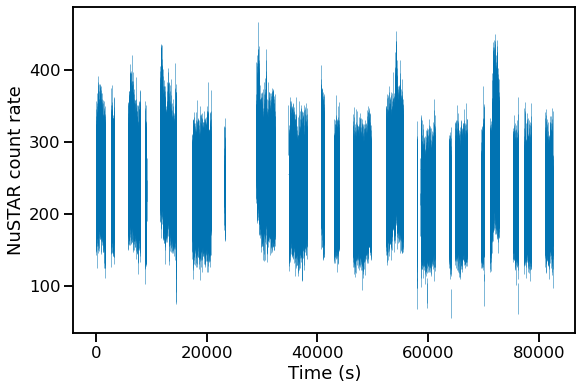

In [42]:
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
PI_max = 960   # 40.0 keV
# PI_max = 1909   # 78.0 keV
events = extract_events(timing_dir + 'nu' + OBSID + 'A01_cl_barycorr.evt', \
            timing_dir + 'nu' + OBSID + 'B01_cl_barycorr.evt')

centroid_A = [455.58026,549.43098]
centroid_B = [460.58411,550.4489]
extraction_radius = 46.783962

events[0].set_xy_weights(centroid=centroid_A)
events[1].set_xy_weights(centroid=centroid_B)


plt.ion()

curveA = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc'))
curveB = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc'))
curve_total = sum_lc(curveA, curveB)
curve_10s = curve_total.rebin(dt_new=10)

t_start = np.min(curve_total.time)

plt.figure(figsize = (9,6))
plt.errorbar(curve_total.time-t_start, curve_total.countrate, xerr=curve_total.dt/2., yerr=curve_total.countrate_err, fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel('NuSTAR count rate')
# plt.close()






In [43]:
gti_lens = np.array([(g[1]-g[0]) for g in events[0].gti])
len_mask = gti_lens > 500.
split_time = minimize_remainder(gti_lens[len_mask], 500,1500)
print(split_time)
ms_bin = 0.0002
f_res = 0.05

# print(events[0].split_by_time(bintime=split_time))
curves_A = [x.to_lc(dt = ms_bin, centroid = centroid_A, radius=extraction_radius) for x in events[0].split_by_time(bintime=split_time)]
curves_B = [x.to_lc(dt = ms_bin, centroid = centroid_B, radius=extraction_radius) for x in events[1].split_by_time(bintime=split_time)]



540.4040404040404


In [44]:
cross_spectra = []
for i in tqdm(range(len(curves_A))):
    cross_file = open(timing_dir + 'analysis_products/cross_spectrum_' + str(int(split_time)) + 's_segment' + str(i) + '.txt', 'rb')
    cross = pickle.load(cross_file)
    cross_file.close()
    cross_spectra.append(cross)



100%|██████████| 59/59 [00:42<00:00,  1.40it/s]


In [47]:
plt.ion()

averaged_cross = cross_spectra[0]

averaged_cross.m = len(cross_spectra)

for i in range(len(cross_spectra))[1:]:
    averaged_cross.power += cross_spectra[i].power
    averaged_cross.unnorm_power += cross_spectra[i].unnorm_power
    averaged_cross.power_err += np.square(cross_spectra[i].power_err)
    averaged_cross.nphots1 += cross_spectra[i].nphots1
    averaged_cross.nphots2 += cross_spectra[i].nphots2
    
averaged_cross.power = averaged_cross.power/averaged_cross.m
averaged_cross.unnorm_power = averaged_cross.unnorm_power/averaged_cross.m
averaged_cross.power_err = np.sqrt(averaged_cross.power_err)/averaged_cross.m
averaged_cross.nphots1 = averaged_cross.nphots1/averaged_cross.m
averaged_cross.nphots2 = averaged_cross.nphots2/averaged_cross.m


# Scan for QPOs

In [48]:
f_min = np.min(averaged_cross.freq)
f_max = np.min([2000., (np.max(averaged_cross.freq))])
freqs, chisq0, chisq, dof = QPO_scan(averaged_cross, f_min=f_min, f_max=f_max, f_bin = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

[ 0.00235811 -1.44458798]


100%|██████████| 500/500 [49:45<00:00,  5.97s/it] 


In [49]:
print(chisq0/dof)
plt.figure(figsize=(9,6))
plt.plot(freqs, (chisq - chisq0))
plt.xscale('log')
plt.ylabel(r'$\Delta\chi^{2}$')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig(plot_dir + 'QPO_scan.pdf')
plt.close()

0.9786847266561607


In [50]:
peaks, _ = scipy.signal.find_peaks(-(chisq - chisq0), height = 10.0)
QPO_candidates = []
f_mask = (averaged_cross.freq > f_min) * (averaged_cross.freq < f_max) 
xdata = averaged_cross.freq[f_mask]
ydata = averaged_cross.power[f_mask]
sigma = averaged_cross.power_err[f_mask]

popt_arr, pcov_arr = fit_peaks(xdata, ydata, sigma, freqs[peaks])

sigma_arr = []

for i in range(len(popt_arr)):
    print(popt_arr[i])
    print(np.sqrt(np.diag(pcov_arr[i])))
    sigma_arr.append(np.sqrt(np.diag(pcov_arr[i])))
sigma_arr = np.array(sigma_arr)
    

[ 2.37314991e+02  1.75903910e+01  6.34624337e-02  2.35787958e-03
 -1.44460609e+00]
[7.64870459e+00 2.82134392e+01 7.19603907e-02 4.53832427e-04
 3.62524687e-02]
[ 3.30221053e+02  1.56533617e+02  5.49261482e-02  2.35801990e-03
 -1.44459502e+00]
[5.46443750e-01 1.14683794e+02 2.84549264e-02 4.53851382e-04
 3.62518599e-02]


In [51]:
plt.ion()

f_res = 0.05
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real, xerr=temp_err, yerr=averaged_cross_log.power_err, fmt='none', lw=0.5)
plt.plot(averaged_cross_log.freq, Lorentzian_power(averaged_cross_log.freq, *(popt_arr[1])), color='red')
plt.xscale('log')
plt.ylim((1e-6,100.))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'averaged_cross_spectrum_' + str(int(split_time)) + 's_QPO_fit.pdf')
plt.close()

